## Import Modules and Libraries

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, add, concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

import tensorflow as tf

Using TensorFlow backend.


## Import CiFAR Dataset
- It is a more advance dataset compared to MNIST
- It has 10 classes 
- The dimension of the images are 32x32x3 since it is a RGB image
- Shown below are the classses in the CiFAR dataset
- Like MNIST, CiFAR also has 50K training images and labels as well as 10K test images and labels

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


## Print training data dimensions

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


## Displaying a sample from each class of the dataset

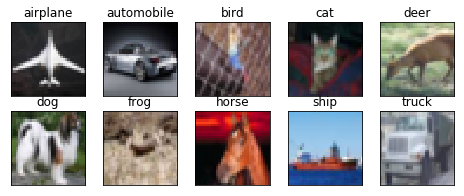

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for plotting accuracy and loss during model training

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Accuracy Calculation for a model

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Data Float Conversion , remapping pixel values between 0 & 1, and One-Hot encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Model Architecture and Compiling Model
- This model is built using functional API and not Sequential model
- This model consists of various types of convolutions like Depthwise Separable convolution, Dilated convolution, Spatial Separable convolution, and grouped convolutions

- ### Separable Convolution:
  
  ![](SeparableConv.gif)
  - They are extensively used in Inception and Xception networks
  - Instead of using 3x3, we use 3x1 and then 1x3 over an image
  - This reduces the parameters by around 66%
  - The accuracy drop is around 0.2-0.8%
  
- ### Depthwise Convolution:

  ![](depthwise.gif)
  - We divide the depth i.e. the channels and convolve witht a kernel on each of the channel
  - Then we concaenatet the output and use 1x1 to get the output
  - Huge number of parameters are reduced using depthwise convolution
  - Accuracy drop is around 0.2-0.6 %
  
  
- ### Dilated Convolution

![](dilated.gif)
  - It is mostly used for segmentation network
  - It increases the receptive field of the network

- ### Grouped Convolutions:
  
  ![](grouped.png)
  - Different types of convolutions are used parallely to improve the detection result
  - It is useful to detect objects with different sizes in the network
  
  
  ## Architecture
  ![](https://2.bp.blogspot.com/-HQo2Kx39Q6A/WsqZQn5pJHI/AAAAAAAAVhY/FBkgOeS06vQNvZN2KI2hhGZmfS1cNPg8wCLcBGAs/s1600/enasdiscoverednetwork.png)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)

In [9]:
# Defining Model Input
input = Input(shape=(32, 32, 3,))

# Dropout rate
drop = 0.35

#******************** Convolution Block - 1 ***************************
conv_layer1 = SeparableConv2D(32, 5, 5, border_mode='same', name='conv1')(input)
BN_1 = BatchNormalization(name='BN_1')(conv_layer1)
Activation_1 = Activation('relu', name='Activation_1')(BN_1)

conv_layer2 = Conv2D(32, 5, 5, border_mode='same', name='conv2')(Activation_1) 
BN_2 = BatchNormalization(name='BN_2')(conv_layer2)
Activation_2 = Activation('relu', name='Activation_2')(BN_2)

conv_layer3 = Conv2D(32, 5, 5, border_mode='same', name='conv3')(Activation_2) 
BN_3 = BatchNormalization(name='BN_3')(conv_layer3)
Activation_3 = Activation('relu', name='Activation_3')(BN_3)

skip_1 = concatenate([Activation_3, Activation_1])
conv_layer4 = SeparableConv2D(32, 5, 5, border_mode='same', name='conv4')(skip_1)
BN_4 = BatchNormalization(name='BN_4')(conv_layer4)
Activation_4 = Activation('relu', name='Activation_4')(BN_4)
#**********************************************************************


#******************* Transition Block - 1 **************************
skip_2 = concatenate([Activation_1, Activation_4])
maxpool_1 = MaxPooling2D(2, name='MP1')(skip_2)
#*******************************************************************

############# Skip connection Layers ####################
# For Convolution Block - 2
Activation_1_2 = Lambda(space_to_depth_x2)(Activation_1)
Activation_2_2 = Lambda(space_to_depth_x2)(Activation_2)
Activation_3_2 = Lambda(space_to_depth_x2)(Activation_3)
Activation_4_2 = Lambda(space_to_depth_x2)(Activation_4)

# For Convolution Block - 3
Activation_1_3 = Lambda(space_to_depth_x4)(Activation_1)
Activation_2_3 = Lambda(space_to_depth_x4)(Activation_2)
Activation_3_3 = Lambda(space_to_depth_x4)(Activation_3)
Activation_4_3 = Lambda(space_to_depth_x4)(Activation_4)
#########################################################

#***************** Convolution Block - 2 ****************************
conv_layer5 = SeparableConv2D(32, 3, 3, border_mode='same', name='conv5')(maxpool_1)
BN_5 = BatchNormalization(name='BN_5')(conv_layer5)
Activation_5 = Activation('relu', name='Activation_5')(BN_5)

skip_3 = concatenate([Activation_1_2, Activation_4_2, Activation_5])
conv_layer6 = Conv2D(32, 5, 5, border_mode='same', name='conv6')(skip_3)
BN_6 = BatchNormalization(name='BN_6')(conv_layer6)
Activation_6 = Activation('relu', name='Activation_6')(BN_6)

skip_4 = concatenate([Activation_6, Activation_5, Activation_4_2, Activation_3_2])
conv_layer7 = SeparableConv2D(32, 3, 3, border_mode='same', name='conv7')(skip_4)
BN_7 = BatchNormalization(name='BN_7')(conv_layer7)
Activation_7 = Activation('relu', name='Activation_7')(BN_7)

skip_5 = concatenate([Activation_7, Activation_6, Activation_5, Activation_4_2, Activation_3_2, Activation_1_2])
conv_layer8 = SeparableConv2D(32, 5, 5, border_mode='same', name='conv8')(skip_5)
BN_8 = BatchNormalization(name='BN_8')(conv_layer8)
Activation_8 = Activation('relu', name='Activation_8')(BN_8)
#********************************************************************

#***************** Transition Block - 2 *****************************
skip_6 = concatenate([Activation_8, Activation_7, Activation_5, Activation_4_2, Activation_1_2])
maxpool_2 = MaxPooling2D(2, name='MP2')(skip_6)
#********************************************************************

############# Skip connection Layers ####################
# For Convolution Block - 2
Activation_5_3 = Lambda(space_to_depth_x2)(Activation_5)
Activation_6_3 = Lambda(space_to_depth_x2)(Activation_6)
Activation_7_3 = Lambda(space_to_depth_x2)(Activation_7)
Activation_8_3 = Lambda(space_to_depth_x2)(Activation_8)
#########################################################


#***************** Convolution Block - 3 ****************************
skip_7 = concatenate([maxpool_2, Activation_6_3])
conv_layer9 = Conv2D(32, 5, 5, border_mode='same', name='conv9')(skip_7) 
BN_9 = BatchNormalization(name='BN_9')(conv_layer9)
Activation_9 = Activation('relu', name='Acticatn_9')(BN_9)

skip_8 = concatenate([Activation_9, Activation_4_3, Activation_7_3, Activation_2_3, Activation_1_3])
conv_layer10 = SeparableConv2D(32, 5, 5, border_mode='same', name='conv10')(skip_8)
BN_10 = BatchNormalization(name='BN_10')(conv_layer10)
Activation_10 = Activation('relu', name='Acticatn_10')(BN_10)

skip_9 = concatenate([Activation_10, Activation_9, Activation_5_3, Activation_3_3, Activation_2_3])
conv_layer11 = Conv2D(32, 3, 3, border_mode='same', name='conv11')(skip_9) 
BN_11 = BatchNormalization(name='BN_11')(conv_layer11)
Activation_11 = Activation('relu', name='Acticatn_11')(BN_11)

skip_10 = concatenate([Activation_11, Activation_10, Activation_3_3, Activation_7_3, Activation_4_3, Activation_5_3])
conv_layer12 = SeparableConv2D(10, 5, 5, border_mode='same', name='conv12')(skip_10)
#***************************************************************************

#*********************** Output Layer **************************************
skip_11 = concatenate([conv_layer12, Activation_10, Activation_4_3, Activation_7_3])
penultimate = Conv2D(10, 8, 8, name='Penultimate')(skip_11)
penultimate = Flatten()(penultimate)
output = Activation('softmax')(penultimate)
#***************************************************************************

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="conv1", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), name="conv2", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), name="conv3", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="conv4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32,

## Model Summary

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (SeparableConv2D)         (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
Activation_1 (Activation)       (None, 32, 32, 32)   0           BN_1[0][0]                       
__________________________________________________________________________________________________
conv2 (Con

## Training and tracking progress

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
97/97 [==============================] - 48s 499ms/step - loss: 10.0367 - acc: 0.2707 - val_loss: 9.9505 - val_acc: 0.2995
Epoch 2/100
97/97 [==============================] - 40s 416ms/step - loss: 9.8764 - acc: 0.3241 - val_loss: 9.8878 - val_acc: 0.3240
Epoch 3/100
97/97 [==============================] - 38s 393ms/step - loss: 9.8138 - acc: 0.3461 - val_loss: 9.8967 - val_acc: 0.3265
Epoch 4/100
97/97 [==============================] - 38s 394ms/step - loss: 9.8025 - acc: 0.3582 - val_loss: 9.8676 - val_acc: 0.3339
Epoch 5/100
97/97 [==============================] - 38s 392ms/step - loss: 9.7329 - acc: 0.3710 - val_loss: 9.9346 - val_acc: 0.3221
Epoch 6/100
97/97 [==============================] - 38s 393ms/step - loss: 9.7461 - acc: 0.3775 - val_loss: 9.8795 - val_acc: 0.3319
Epoch 7/100
97/97 [==============================] - 38s 394ms/step - loss: 9.6974 - acc: 0.3877 - val_loss: 9.8412 - val_acc: 0.3467
Epoch 8/100
97/97 [==============================] - 38s 394m

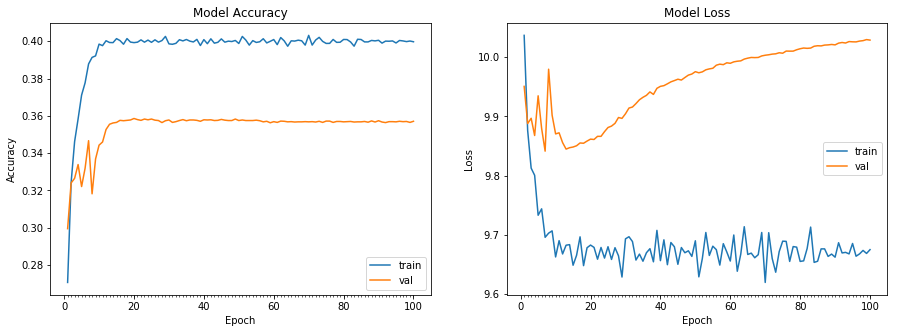

Accuracy on test data is: 35.71


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))